# Multithreading

## What are threads?
Threads are **execution units within a process** that can run simultaneously. While processes are separate, threads run in a **shared memory** space (heap).

<!-- <img src="./imgs/what-are-threads.png" width=500px> -->

<br>
<img src="imgs/stack_heap_threads.svg" width=450px>
<br>

## Starting Julia with multiple threads

By default, Julia starts with a single *user thread*. We must tell it explicitly to start multiple user threads. There are a couple of ways to do this:

* Environment variable: `export JULIA_NUM_THREADS=4`
* Command line argument: `julia --threads 4` or `julia -t 4`

**It is currently not (easily) possible to change the number of threads at runtime!**

For Jupyter, we create another kernel that starts Julia with multiple threads.

In [2]:
using IJulia
installkernel("Julia (4 threads)", "--project=@.", env=Dict("JULIA_NUM_THREADS"=>"4"))

[ Info: Installing Julia (4 threads) kernelspec in /Users/carstenbauer/Library/Jupyter/kernels/julia-_4-threads_-1.10


"/Users/carstenbauer/Library/Jupyter/kernels/julia-_4-threads_-1.10"

Afterwards, we need to **refresh the page** and select the new `Julia (4 threads) 1.10` kernel in the top right corner. (Restart Jupyter if the kernel doesn't show up.)

We can readily check how many threads we are running:

In [2]:
Threads.nthreads()

4

### User threads vs default threads

Technically, the Julia process is also spawning multiple threads already in "single-threaded" mode, like
* a thread for unix signal listening
* multiple OpenBLAS threads for BLAS/LAPACK operations
* GC threads

We call the threads that we can actually run computations on *user threads* or *Julia threads*.

In [3]:
using LinearAlgebra
BLAS.get_num_threads()

4

## Where are my threads running?

In [4]:
using ThreadPinning

In [5]:
threadinfo()

Hostname: 	pc2macmini.fritz.box
CPU(s): 	1 x Apple M1
CPU target: 	apple-m1
Cores: 		8 (8 CPU-threads)
Core kinds: 	4 "efficiency cores", 4 "performance cores".
NUMA domains: 	1 (8 cores each)

Unsupported OS: Won't be able to highlight Julia threads.

Julia threads: 	4

CPU socket 1
  0,1,2,3,4,5,6,7


# = Julia thread, # = >1 Julia thread, # = Efficiency core


<img src="imgs/threadinfo.png" width=1000px>

## Task-based multithreading

Julia implements **task-based** multithreading. In this paradigm, a task - e.g. a computational piece of a code - is marked for **parallel** execution on **any** of the Julia threads. Julia's **dynamic scheduler** will put the task on a thread and trigger the execution of the task.

<br>
<!-- <img src="imgs/task-based-parallelism.png" width=768px> -->
<img src="imgs/tasks_threads_cores.svg" width=650px>
</br>

Task-based multithreading: **The user should think about tasks and not threads**.
* By default, the user does not control on which thread a task will run (the task might even [migrate](https://docs.julialang.org/en/v1/manual/multi-threading/#man-task-migration) between threads!).

**Advantages:**
* high-level abstraction: one can spawn many tasks (>> number of threads)
* nestable multithreading

**Disadvantages:**
* dynamic scheduling overhead
* uncertainty and potentially suboptimal task → thread assignment
  * can get in the way when performance engineering

### Spawning tasks
`Threads.@spawn` spawns a task to be run on any Julia thread. Specifically, it creates a `Task` and schedules it for execution on an available Julia thread (we don't control which one!).

Note that `Threads.@spawn` is **asynchronous** and **non-blocking**, that is, it doesn't wait for the task to actually run but immediately returns a `Task`.

In [6]:
using Base.Threads # afterwards we can just write @spawn instead of Threads.@spawn

In [7]:
@spawn 3+3

Task (done) @0x000000015284d5f0

We can fetch the result of a task with `fetch`.

In [8]:
t = @spawn 3+3
fetch(t)

6

While `@spawn` returns right away, `fetch` is **blocking** as it has to wait for the task to actually finish.

In [9]:
@time t = @spawn begin
    sleep(3)
    return 3+3
end
@time fetch(t)

  0.000062 seconds (31 allocations: 2.203 KiB)
  2.980782 seconds (183 allocations: 12.391 KiB)


6

We can use the macro `@sync` to synchronize all (lexically) encompassed asynchronous operations (`@spawn`).

In [ ]:
@time @sync t = @spawn begin
    sleep(3)
    return 3+3
end
@time fetch(t)

#### Example: multithreaded `map`

`tmap`: *threaded map*

In [10]:
function tmap(f, collection)
    tasks = map(x -> @spawn(f(x)), collection)  # for each x ∈ collection, spawn a task to compute f(x)
    return fetch.(tasks)                        # fetch and return all the results
end

tmap (generic function with 1 method)

In [12]:
M = [rand(200,200) for i in 1:8];

In [13]:
tmap(svdvals, M)

8-element Vector{Vector{Float64}}:
 [100.62249305056245, 7.88646934027232, 7.738424398190583, 7.684647332638145, 7.5955563663360355, 7.54525835028386, 7.434152374139923, 7.392605747663393, 7.315350134852897, 7.236032858026454  …  0.28381858953575967, 0.23624844098154285, 0.21190873934466117, 0.20740526443551657, 0.14148730549188718, 0.125903016186162, 0.09934751787890563, 0.06124817558574783, 0.03666674027579161, 0.028752830575313602]
 [99.98124113374108, 8.19059991145892, 7.871395611108532, 7.682669050507281, 7.598540699412352, 7.50541605183779, 7.411383611865332, 7.345351822575895, 7.261887000920758, 7.214714039839069  …  0.31685723902697305, 0.2431016967126658, 0.23280914667136146, 0.20912133195913862, 0.16634586482804345, 0.14993800040722546, 0.12640526454207568, 0.07738715092036051, 0.07183833574104066, 0.030370245962765816]
 [100.68868828635557, 7.953719200440757, 7.82872700187935, 7.75887182981286, 7.6707904830474964, 7.558778777804758, 7.473621312672282, 7.39617994576773, 7.349

In [14]:
using BenchmarkTools

In [15]:
@btime tmap($svdvals, $M) samples=10 evals=3;
@btime map($svdvals, $M) samples=10 evals=3;

  14.578 ms (113 allocations: 3.38 MiB)
  30.832 ms (65 allocations: 3.38 MiB)


If you use multithreading in Julia in combination with BLAS/LAPACK functions, it is important to carefully consider and configure the [interplay between Julia threads and BLAS threads](https://carstenbauer.github.io/ThreadPinning.jl/stable/explanations/blas/).

Easiest way out: turn of BLAS/LAPACK multithreading.

In [16]:
BLAS.set_num_threads(1)

In [17]:
@btime tmap($svdvals, $M) samples=10 evals=3;
@btime map($svdvals, $M) samples=10 evals=3;

  7.807 ms (113 allocations: 3.38 MiB)
  28.677 ms (65 allocations: 3.38 MiB)


#### Example: multithreading for-loops

In [20]:
using ThreadPinning.Utility: taskid

In [22]:
@sync for i in 1:8
    @spawn println("Task ", taskid(), " is running iteration ", i, " on thread ", threadid())
end

Task 858898612978605224 is running iteration 4 on thread 1
Task 4163829666221995616 is running iteration 2 on thread 4
Task 4447764555518893346 is running iteration 5 on thread 4
Task 1520382692800496960 is running iteration 3 on thread 3
Task 10649719027710713544 is running iteration 6 on thread 4
Task 16492472265793183757 is running iteration 8 on thread 4
Task 13570975818238066913 is running iteration 1 on thread 2
Task 18206169384540845315 is running iteration 7 on thread 1


##### `@threads`

* **Splits up the iteration space into `nthreads()` contiguous chunks**
* Creates a task for each chunk.

In [23]:
@threads for i in 1:8
    println("Task ", taskid(), " is running iteration ", i, " on thread ", threadid())
end

Task 1881879333544461475 is running iteration 1 on thread 1
Task 14826714216980522000 is running iteration 5 on thread 3
Task 1881879333544461475 is running iteration 2 on thread 2
Task 14826714216980522000 is running iteration 6 on thread 2
Task 339865449406258305 is running iteration 7 on thread 2
Task 5472231908147987540 is running iteration 3 on thread 4
Task 5472231908147987540 is running iteration 4 on thread 4
Task 339865449406258305 is running iteration 8 on thread 3


### Load-balancing and chunking

If there are many tasks (e.g. many more than available threads), Julia's scheduler balances the load of these tasks among threads.

In [142]:
using StatsPlots
using ChunkSplitters

The package [ChunkSplitters.jl](https://github.com/m3g/ChunkSplitters.jl) is helpful for chunking (`Iterators.partition` is a built-in alternative).

In [168]:
# this function is purely pedagogical
function tmap_tracking(f, collection; tracker = [UnitRange[] for _ in 1:nthreads()], ntasks=nthreads())
    result = zeros(length(collection))
    @sync for idcs in chunks(collection; n=ntasks)    # chunk up collection into ntasks-many chunks
        Threads.@spawn begin                          # spawn a task for each chunk
            for i in idcs                             # for each element of a that belongs to this chunk/task
                result[i] = f(collection[i])          # apply f
            end
            push!(tracker[threadid()], idcs)          # keep track of which thread ran the task
        end
    end
    return result, tracker
end

tmap_tracking (generic function with 1 method)

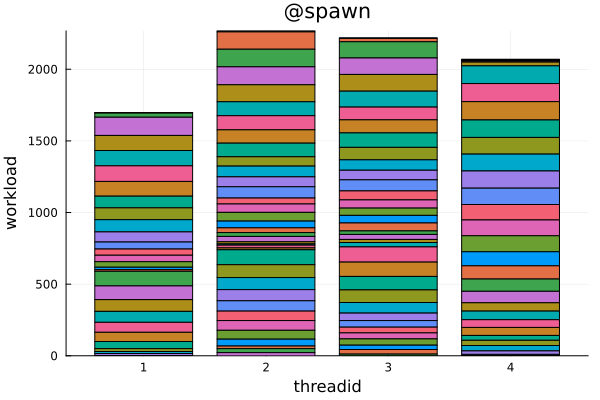

In [186]:
xs = 1:2^7
f(x) = sum(abs2, rand() for _ in 1:(2^14*x)) # computational cost is increasing as a function of x (non-uniform)

result, tracker = tmap_tracking(f, xs; ntasks=length(xs))   # create a task for each element of `a`
# result, tracker = tmap_tracking(f, xs; ntasks=8*nthreads()) # create 8*nthreads() tasks, each handling a chunk of `a`
# result, tracker = tmap_tracking(f, xs; ntasks=4*nthreads()) # create 4*nthreads() tasks, each handling a chunk of `a`
# result, tracker = tmap_tracking(f, xs; ntasks=2*nthreads()) # create 2*nthreads() tasks, each handling a chunk of `a`
# result, tracker = tmap_tracking(f, xs; ntasks=1)            # create a single task, handling all of `a`
# result, tracker = tmap_tracking(f, xs; ntasks=nthreads())   # create nthreads() tasks, each handling a chunk of `a`

# plotting
thread_workloads = zeros(Int, nthreads(), maximum(length, tracker))
for th in eachindex(tracker)
    for (i, ws) in enumerate(tracker[th])
        thread_workloads[th, i] = sum(ws)
    end
end
b = groupedbar(thread_workloads, xlab="threadid", ylab="workload", title="@spawn", legend=false, bar_position=:stack)
display(b)

Note: Since `@threads` divides the iteration range into `nthreads()` chunks there is no load balancing: Each thread gets a single task and that's it.

### Nestable multithreading

#### Example: Recursive Fibonacci series

$$ F(n) = F(n-1) + F(n-2), \qquad F(1) = F(2) = 1$$

We can nest `@spawn` calls freely!

In [189]:
function fib(n)
    n < 2 && return n
    t = @spawn fib(n-2)
    return fib(n-1) + fetch(t)
end

fib (generic function with 1 method)

In [190]:
fib(20)

6765

(Note: Algorithmically, this is a highly inefficient implementation of the Fibonacci series, of course!)

## Opting out of dynamic scheduling

For "traditional HPC", where you tell each thread what to do, you might want to opt out of dynamic scheduling and task migration. 

**Advantages:**

* guaranteed task-thread mapping ("task pinning")
* lower overhead

**Disadvantages:**

* often less portable code (e.g. hardcoded assumptions about the system)
* no (or at least bad) nestability

### `@spawnat`

Julia doesn't have a built-in macro for spawning **sticky** tasks on specific threads but many packages, including [ThreadPinning.jl](https://github.com/carstenbauer/ThreadPinning.jl) and [OhMyThreads.jl](https://github.com/JuliaFolds2/OhMyThreads.jl), provide `@spawnat`.

In [191]:
using ThreadPinning: @spawnat

In [252]:
@spawnat 4 println("Task ", taskid(), " is running on thread ", threadid(), ", and always will be 😉");

Task 9147756047189145984 is running on thread 4, and always will be 😉


### `@threads :static`

For `@threads` there is the `:static` scheduling option to opt-out of Julia's dynamic scheduling.

* **statically** maps tasks/chunks to threads, specifically: task 1 → thread 1, task 2 → thread 2, and so on.

In [ ]:
@threads :dynamic for i in 1:2*nthreads() # :dynamic is the default
    println("Task ", taskid(), " is running iteration ", i, " on thread ", threadid());
end

In [ ]:
@threads :static for i in 1:2*nthreads()
    println("Task ", taskid(), " is running iteration ", i, " on thread ", threadid());
end

For `@threads :static`, every thread handles precisely two iterations!

## Beware of Multithreading: Parallel Summation

In [239]:
data = rand(1_000_000 * Threads.nthreads());

sum(data) # we want to parallelize this

1.9996162856536657e6

### How you should parallelize it

The honest answer is: Simply use a package like, e.g., [OhMyThreads.jl](https://github.com/JuliaFolds2/OhMyThreads.jl). There is no need to roll your own parallel summation (or your own `tmap` 😉).

In [234]:
using OhMyThreads: treduce

treduce(+, data)

1.9997520081494134e6

In [236]:
treduce(+, data) ≈ sum(data)

true

In [238]:
@btime sum($data);
@btime treduce($+, $data);

  729.292 μs (0 allocations: 0 bytes)
  540.041 μs (94 allocations: 7.47 KiB)


But let's assume we want to write a parallel version ourselves.

### Task-focused parallel version

Key questions for task-based parallelisation:
* How to divide the computation into seperate **tasks**?
    * Answer: chunk up the data and perform partial sums.
* How many **tasks** should we create?
    * Answer: since the workload is uniform, `nthreads()` many tasks is a reasonable choice.

In [250]:
function sum_loop_spawn(data; ntasks=nthreads())
    ts = Vector{Task}(undef, ntasks)
    for (c, idcs) in enumerate(chunks(data; n=ntasks))
        ts[c] = @spawn @views sum(data[idcs])
    end
    return sum(fetch.(ts))
end

sum_loop_spawn (generic function with 1 method)

or a bit nicer

In [245]:
function sum_map_spawn(data; ntasks=nthreads())
    ts = map(chunks(data, n=ntasks)) do idcs
        @spawn @views sum(data[idcs])
    end
    return sum(fetch.(ts))
end

sum_map_spawn (generic function with 1 method)

* Conceptually simple and task-focused
  * → We're **explicitly** spawning one task per chunk.
  * → No mention of threads, except in `ntasks=nthreads()`.
* In the latter form, we don't even need a manual pre-allocation (it is hidden in the map operation).

In [246]:
sum_map_spawn(data) ≈ sum(data)

true

In [249]:
@btime sum_loop_spawn($data);
@btime sum_map_spawn($data);

  530.584 μs (34 allocations: 2.52 KiB)
  524.375 μs (34 allocations: 2.52 KiB)


### Mistake 1: Race condition

In [201]:
function sum_threads_naive(data)
    s = zero(eltype(data))
    @threads for x in eachindex(data)
        s += x
    end
    return s
end

sum_threads_naive (generic function with 1 method)

In [202]:
@show sum(data);
@show sum_threads_naive(data);
@show sum_threads_naive(data);

sum(data) = 1.9997520081494136e6
sum_threads_naive(data) = 3.501129653181e12
sum_threads_naive(data) = 3.50080858181e12


**Wrong** result! Even worse, it's **non-deterministic** and different every time!

There is a [race condition](https://en.wikipedia.org/wiki/Race_condition) which typically appear when multiple tasks are modifying shared state simultaneously.

→ If possible, **don't modify shared (i.e. non task-local) state!**

### Mistake 2: Thread-focused rather than task-focused

You might be inclined to write something similar to the following (intentionally written in a slightly more verbose form):

In [203]:
function sum_threads_unsafe(data)
    psums = zeros(eltype(data), nthreads())
    @threads for i in eachindex(data)
        current_sum = psums[threadid()] # read
        new_sum = current_sum + data[i] # "work"
        psums[threadid()] = new_sum     # write
    end
    return sum(psums)
end

sum_threads_unsafe (generic function with 1 method)

Such an approach is generally **unsafe** because Julia's scheduler may **migrate tasks between threads**!
  * For example, a task might start on thread 1, is then paused (say, after "work") and migrated to thread 3, where it finishes execution.
  * → The output of `threadid()` might change within a task! To be safe, [don't use `threadid()`](https://julialang.org/blog/2023/07/PSA-dont-use-threadid/) at all!
  
It also goes against the idea of task-based multithreading, as we're **thinking about threads rather than tasks**.

(Note that, in spite of the comments above, the `threadid()` pattern will often still work correctly. This is because as of Julia 1.10 task migrations are very rare. **You can't rely on it though!**)

### (Performance) Mistake 3: False sharing

In [206]:
function sum_threads_chunks(data; nchunks=nthreads())
    psums = zeros(eltype(data), nchunks)
    @threads for (c, idcs) in enumerate(chunks(data; n=nchunks))
        for i in idcs
            psums[c] += data[i]
        end
    end
    return sum(psums)
end

sum_threads_chunks (generic function with 1 method)

In [207]:
sum_threads_chunks(data) ≈ sum(data)

true

In [208]:
@btime sum($data);
@btime sum_threads_chunks($data);

  729.750 μs (0 allocations: 0 bytes)
  3.727 ms (22 allocations: 2.30 KiB)


Safe, but (horribly) slow?! Why?

* **False sharing** of `psums`
* Also, but less important here: manual loop doesn't SIMD (need to add manual `@simd` + `@inbounds`)

##### Performance issue: [False sharing](https://en.wikipedia.org/wiki/False_sharing)

Why does `sum_threads_chunks` above have bad performance? Although argubaly subtle, this is because different tasks mutate shared data (`psums`) in parallel. There is no *logical* sharing: Tasks access different slots of `psums` and there is no data race. However, CPU cores work on the basis of **cache lines** instead of single elements leading to *implicit* sharing of cache lines.

**Despite its subtlety, false sharing can lead to dramatic slowdown!**

In [209]:
using CpuId

In [210]:
cachelinesize() ÷ sizeof(Float64)

0

<img src="imgs/false_sharing.svg" width=850px>

Different tasks modify the same cache line
* need for synchronization to ensure cache coherency
* performance decreases (dramatically).

Once agin: **The less you modify shared (i.e. non task-local) state, the better!**

##### "Fixed" version

In [211]:
function sum_threads_chunks_local(data; nchunks=nthreads())
    psums = zeros(eltype(data), nchunks)
    @threads for (c, idcs) in enumerate(chunks(data; n=nchunks))
        local s = zero(eltype(data))
        @simd for i in idcs
            @inbounds s += data[i]
        end
        psums[c] = s
    end
    return sum(psums)
end

sum_threads_chunks_local (generic function with 1 method)

* each task/iteration computes a local sum (`s`) independently
* no *frequent* non-local mutation

In [212]:
sum(data) ≈ sum_threads_chunks_local(data)

true

In [213]:
@btime sum($data);
@btime sum_threads_chunks_local($data);

  729.542 μs (0 allocations: 0 bytes)
  520.083 μs (22 allocations: 2.30 KiB)


## Additional comments

### Tools for multi-threading

* [OhMyThreads.jl](https://github.com/JuliaFolds2/OhMyThreads.jl): Simple tools for basic multithreading.
* [ThreadsX.jl](https://github.com/JuliaFolds2/ThreadsX.jl): Parallelized Base functions
* [Tullio.jl](https://github.com/mcabbott/Tullio.jl): Tullio is a very flexible einsum macro ([Einstein notation](https://en.wikipedia.org/wiki/Einstein_notation))
* [(LoopVectorization.jl)](https://github.com/JuliaSIMD/LoopVectorization.jl): Macro(s) for vectorizing loops.
* [(FLoops.jl)](https://github.com/JuliaFolds/FLoops.jl): Fast sequential, threaded, and distributed for-loops for Julia

### Pinning Julia threads to CPU threads/cores

A compute node has a complex topology (two sockets, multiple memory channels/domains). Placing the Julia threads systematically on CPU-threads matters for

* the computation performance of your Julia codes
* fluctuations/noises in benchmarks
* hardware-level performance monitoring

#### ThreadPinning.jl

<!-- <br>
<img src="imgs/threadpinning_pinthreads.svg" width=600px>
</br> -->

`pinthreads(strategy)`
* `:cputhreads` pin to CPU threads (incl. "hypterthreads") one after another
* `:cores:` pin to CPU cores one after another
* `:numa:` round-robin between NUMA domains
* `:sockets:` round-robin between sockets
* `:affinitymask`: according to an external affinity mask (e.g. set by SLURM)

(More? See my short talk at JuliaCon2023 @ MIT: https://youtu.be/6Whc9XtlCC0)

In [253]:
threadinfo()

Hostname: 	pc2macmini.fritz.box
CPU(s): 	1 x Apple M1
CPU target: 	apple-m1
Cores: 		8 (8 CPU-threads)
Core kinds: 	4 "efficiency cores", 4 "performance cores".
NUMA domains: 	1 (8 cores each)

Unsupported OS: Won't be able to highlight Julia threads.

Julia threads: 	4

CPU socket 1
  0,1,2,3,4,5,6,7


# = Julia thread, # = >1 Julia thread, # = Efficiency core


In [254]:
pinthreads(:cores)
threadinfo()

Hostname: 	pc2macmini.fritz.box
CPU(s): 	1 x Apple M1
CPU target: 	apple-m1
Cores: 		8 (8 CPU-threads)
Core kinds: 	4 "efficiency cores", 4 "performance cores".
NUMA domains: 	1 (8 cores each)

Unsupported OS: Won't be able to highlight Julia threads.

Julia threads: 	4

CPU socket 1
  0,1,2,3,4,5,6,7


# = Julia thread, # = >1 Julia thread, # = Efficiency core


We'll explore the effect of thread pinning on performance in more detail later → **daxpy_cpu exercise**

### Garbage collection

If it gets triggered, it stops the world (all threads) for clearing up memory.

Hence, when using multithreading, it is even more important to **avoid heap allocations!**

(If you can't avoid allocations, consider using multiprocessing instead.)

### Atomic operations and locks

See [Atomic Operations](https://docs.julialang.org/en/v1/manual/multi-threading/#Atomic-Operations) and/or [Data-race freedom](https://docs.julialang.org/en/v1/manual/multi-threading/#Data-race-freedom) in the Julia doc for more information. In general, one should avoid using them as much as possible since they actually limit the parallelization by serialized executions (especially if you don't know what you're doing). That said, locks can be an effective way to use a data structures that themselves aren't thread safe, e.g. `Dict`.